In [8]:
# =======================
# EDA  - BigBasket
# =======================

# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: better plot style
plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (12, 6)

# 2. Load dataset (update filename if different)
df = pd.read_csv("Bigbasketcleaned_dataset.csv")  # <-- Change path if needed

# 3. Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# 4. Quick look
print("Shape of dataset:", df.shape)
print("\nSample rows:")
print(df.head())

# 5. Basic cleaning
# Strip spaces from string columns
for col in df.select_dtypes(include='object'):
    df[col] = df[col].str.strip()

# 6. Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Shape of dataset: (27555, 10)

Sample rows:
   index                                            product  \
0      1             Garlic Oil - Vegetarian Capsule 500 mg   
1      2                              Water Bottle - Orange   
2      3                     Brass Angle Deep - Plain, No.2   
3      4  Cereal Flip Lid Container/Storage Jar - Assort...   
4      5                 Creme Soft Soap - For Hands & Body   

                 category           sub_category              brand  \
0        Beauty & Hygiene              Hair Care  Sri Sri Ayurveda    
1  Kitchen, Garden & Pets  Storage & Accessories         Mastercook   
2    Cleaning & Household            Pooja Needs                Trm   
3    Cleaning & Household   Bins & Bathroom Ware             Nakoda   
4        Beauty & Hygiene       Bath & Hand Wash              Nivea   

   sale_price  market_price                      type  rating  \
0       220.0         220.0          Hair Oil & Serum     4.1   
1       180.0       

Top categories by unique product count (top 15):


,category,unique_products
0,Beauty & Hygiene,6839
1,Gourmet & World Food,4109
2,"Kitchen, Garden & Pets",3186
3,Snacks & Branded Foods,2454
4,Cleaning & Household,2411
5,"Foodgrains, Oil & Masala",1997
6,Beverages,756
7,"Bakery, Cakes & Dairy",752
8,Baby Care,549
9,Fruits & Vegetables,353


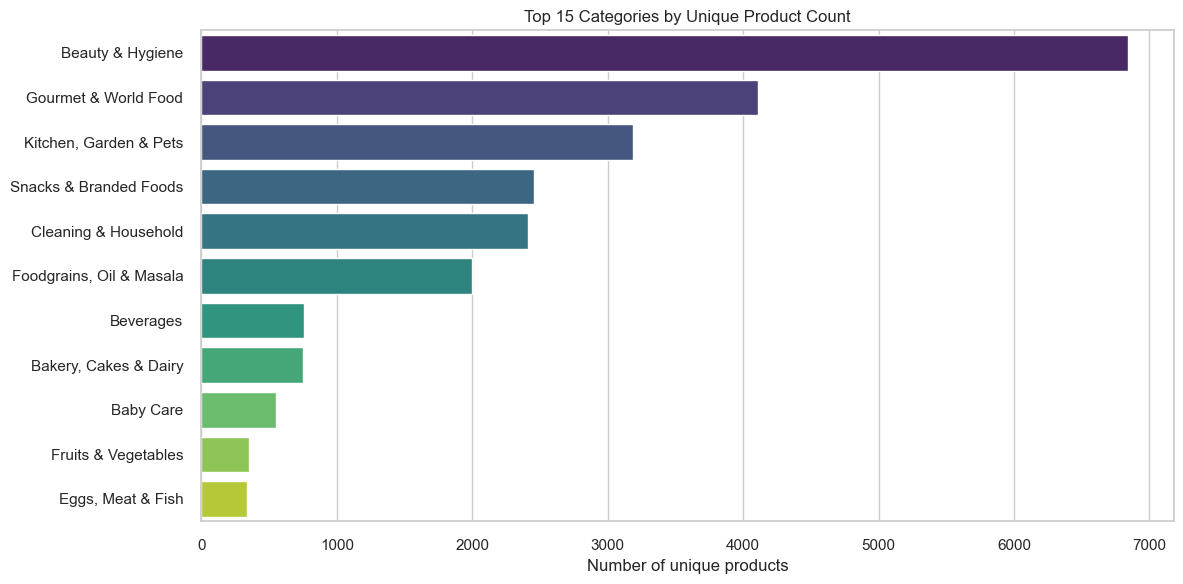

Saved: q1_top_categories_count.png, q1_top_categories_count.csv (and interactive HTML if available)


In [ ]:
# Question 1: Which product categories have the highest number of unique products listed?

# Q1: Top Categories by Product Count
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# Safety / sanity checks
if 'category' not in df.columns:
    raise KeyError("Column 'category' not found in df.")

# Use 'product' if present to count unique product listings; else count rows per category
id_col = 'product' if 'product' in df.columns else None

if id_col:
    cat_counts = df.groupby('category')[id_col].nunique().sort_values(ascending=False).rename("unique_products").reset_index()
else:
    cat_counts = df['category'].value_counts().rename_axis('category').reset_index(name='count')
    cat_counts = cat_counts.rename(columns={'count':'unique_products'})

# Top N to display
TOP_N = 15
top_cats = cat_counts.head(TOP_N).copy()

# Print quick table
print("Top categories by unique product count (top {}):".format(TOP_N))
display(top_cats)

# Static bar plot (matplotlib/seaborn)
plt.figure(figsize=(12,6))
sns.barplot(data=top_cats, y='category', x='unique_products', palette='viridis')
plt.title(f"Top {TOP_N} Categories by Unique Product Count")
plt.xlabel("Number of unique products")
plt.ylabel("")
plt.tight_layout()
plt.savefig("q1_top_categories_count.png", dpi=150)
plt.show()

# Optional interactive bar (Plotly) — saves HTML
try:
    fig = px.bar(top_cats.sort_values('unique_products'), x='unique_products', y='category', orientation='h',
                 title=f"Top {TOP_N} Categories by Unique Product Count",
                 labels={'unique_products':'Unique product count','category':'Category'},
                 hover_data=['unique_products'])
    fig.write_html("q1_top_categories_count.html")
    # fig.show()  
except Exception as e:
    print("Plotly interactive plot skipped (Plotly not available or error):", e)

# Save CSV
top_cats.to_csv("q1_top_categories_count.csv", index=False)
print("Saved: q1_top_categories_count.png, q1_top_categories_count.csv (and interactive HTML if available)")


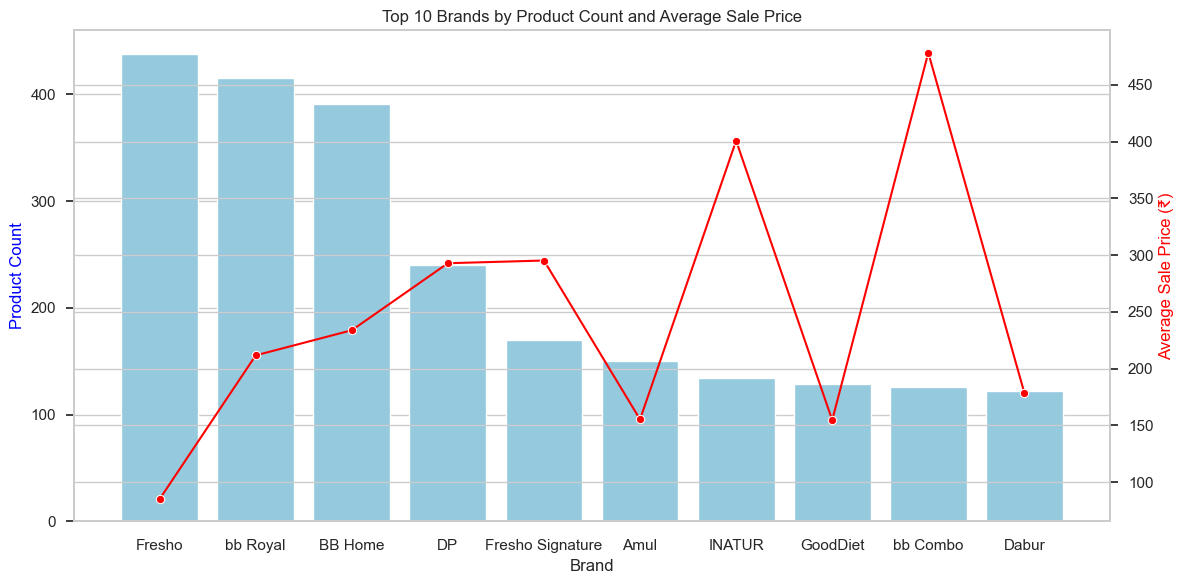

Insights for Q2:
- Fresho has the highest product count at 438 products.
- Brands with higher product counts do not always have the highest average sale prices.
- The red line shows average pricing, indicating some brands position themselves in premium categories.


In [12]:
# Q2: Top 10 brands by product count & average price

# Safety check
if 'brand' not in df.columns:
    raise KeyError("Column 'brand' not found in df.")
if 'sale_price' not in df.columns:
    raise KeyError("Column 'sale_price' not found in df.")

# Group by brand
brand_stats = (
    df.groupby('brand')
      .agg(product_count=('product', 'nunique'),
           avg_price=('sale_price', 'mean'))
      .sort_values('product_count', ascending=False)
      .head(10)
      .reset_index()
)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for counts
sns.barplot(data=brand_stats, x='brand', y='product_count', ax=ax1, color='skyblue')
ax1.set_ylabel("Product Count", color="blue")
ax1.set_xlabel("Brand")
ax1.set_title("Top 10 Brands by Product Count and Average Sale Price")

# Add line plot for average price on secondary axis
ax2 = ax1.twinx()
sns.lineplot(data=brand_stats, x='brand', y='avg_price', ax=ax2, marker='o', color='red')
ax2.set_ylabel("Average Sale Price (₹)", color="red")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Insights
print("Insights for Q2:")
print(f"- {brand_stats.iloc[0,0]} has the highest product count at {brand_stats.iloc[0,1]} products.")
print("- Brands with higher product counts do not always have the highest average sale prices.")
print("- The red line shows average pricing, indicating some brands position themselves in premium categories.")


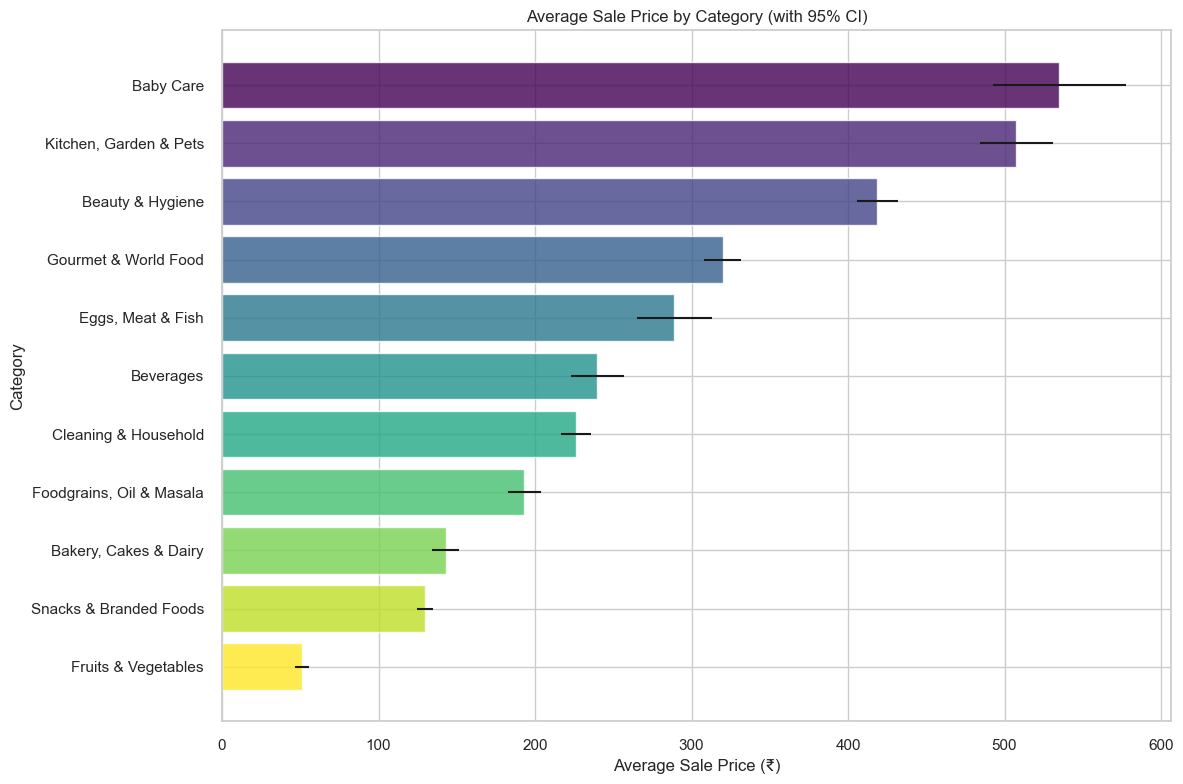

Insights for Q3:
- The category with the highest average price is 'Baby Care' at ₹534.95 (95% CI: ₹492.41 - ₹577.48).
- Categories with larger standard errors have wider confidence intervals, often due to fewer product listings or high price variability.
- Narrow CI bars indicate more stable and consistent pricing within that category.


In [16]:
# =======================
# Q3: Category-wise average sale price with 95% CI
# =======================

import numpy as np
from scipy import stats

# Safety check
if 'category' not in df.columns:
    raise KeyError("Column 'category' not found in df.")
if 'sale_price' not in df.columns:
    raise KeyError("Column 'sale_price' not found in df.")

# Group and calculate statistics
cat_stats = df.groupby('category').agg(
    count=('sale_price', 'count'),
    mean=('sale_price', 'mean'),
    std=('sale_price', 'std')
).reset_index()

# Standard Error
cat_stats['se'] = cat_stats['std'] / np.sqrt(cat_stats['count'])

# 95% Confidence Interval
cat_stats['ci95_lo'] = cat_stats['mean'] - 1.96 * cat_stats['se']
cat_stats['ci95_hi'] = cat_stats['mean'] + 1.96 * cat_stats['se']

# Sort by mean for plotting
cat_stats = cat_stats.sort_values('mean', ascending=False)

# Plot bars
plt.figure(figsize=(12, 8))
bars = plt.barh(
    y=cat_stats['category'],
    width=cat_stats['mean'],
    xerr=1.96 * cat_stats['se'],
    capsize=5,
    color=plt.cm.viridis(np.linspace(0, 1, len(cat_stats))),
    alpha=0.8
)
plt.xlabel("Average Sale Price (₹)")
plt.ylabel("Category")
plt.title("Average Sale Price by Category (with 95% CI)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Insights
print("Insights for Q3:")
print(f"- The category with the highest average price is '{cat_stats.iloc[0,0]}' "
      f"at ₹{cat_stats.iloc[0,2]:.2f} (95% CI: ₹{cat_stats.iloc[0,5]:.2f} - ₹{cat_stats.iloc[0,6]:.2f}).")
print("- Categories with larger standard errors have wider confidence intervals, often due to fewer product listings or high price variability.")
print("- Narrow CI bars indicate more stable and consistent pricing within that category.")


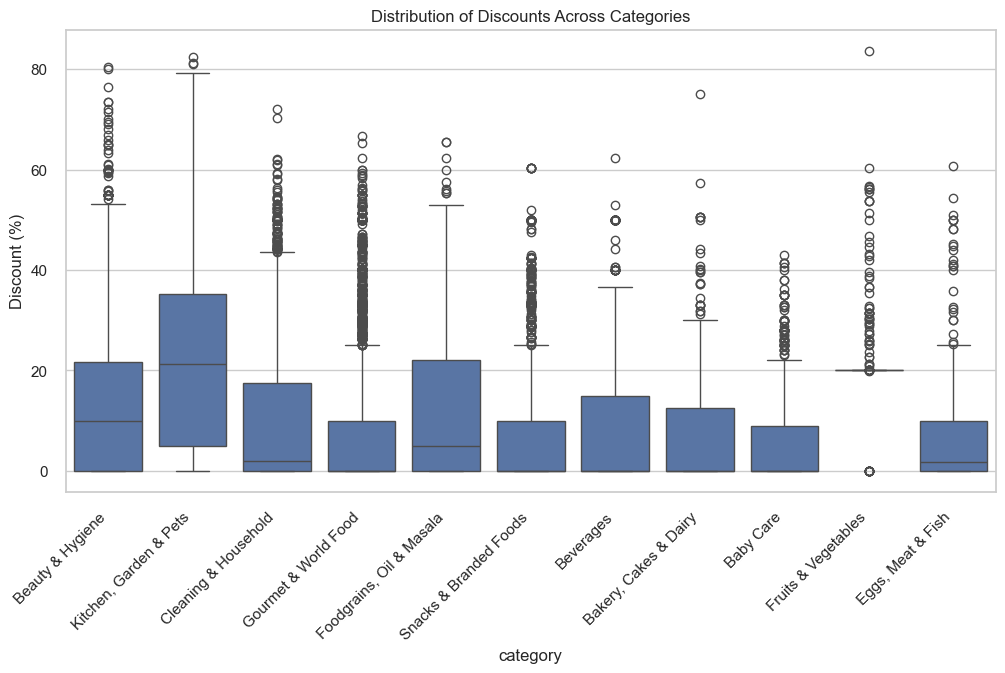


Discount statistics by category:
                           count   mean    std  min   25%    50%    75%    max
category                                                                      
Baby Care                  610.0   5.85  10.02  0.0   0.0   0.00   8.90  43.00
Bakery, Cakes & Dairy      851.0   7.66  10.40  0.0   0.0   0.00  12.42  75.00
Beauty & Hygiene          7867.0  12.34  13.86  0.0   0.0  10.00  21.60  80.50
Beverages                  885.0   9.57  14.04  0.0   0.0   0.00  15.00  62.25
Cleaning & Household      2675.0  10.79  14.33  0.0   0.0   2.00  17.45  72.00
Eggs, Meat & Fish          350.0   8.06  11.85  0.0   0.0   1.79  10.00  60.67
Foodgrains, Oil & Masala  2676.0  11.84  14.07  0.0   0.0   5.00  22.10  65.52
Fruits & Vegetables        557.0  21.25   7.50  0.0  20.0  20.00  20.00  83.67
Gourmet & World Food      4690.0   7.86  12.64  0.0   0.0   0.00  10.00  66.69
Kitchen, Garden & Pets    3580.0  22.18  17.92  0.0   5.0  21.21  35.18  82.51
Snacks & Branded F

In [20]:
# Q4: Distribution of Discounts Across Categories

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure required columns exist
required_cols = ['market_price', 'sale_price', 'category']
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in df.")

# Calculate discount percentage
df['discount'] = ((df['market_price'] - df['sale_price']) / df['market_price']) * 100

# Plot distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='category', y='discount')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Discount (%)")
plt.title("Distribution of Discounts Across Categories")
plt.show()

# Insights
discount_stats = df.groupby('category')['discount'].describe().round(2)
print("\nDiscount statistics by category:")
print(discount_stats)


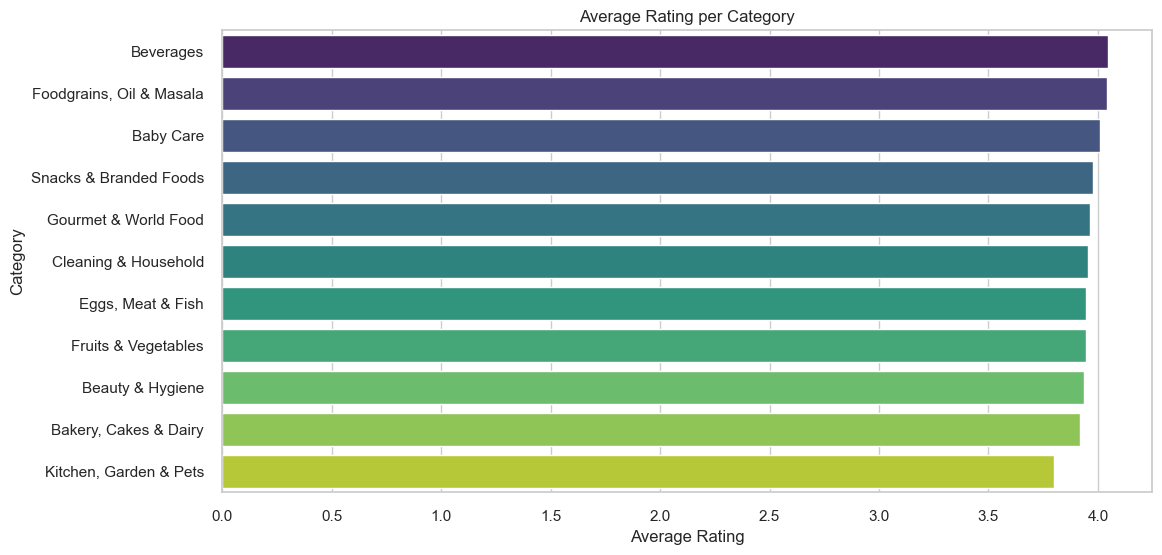


Average rating per category:
category
Beverages                   4.04
Foodgrains, Oil & Masala    4.04
Baby Care                   4.01
Snacks & Branded Foods      3.98
Gourmet & World Food        3.96
Cleaning & Household        3.95
Eggs, Meat & Fish           3.94
Fruits & Vegetables         3.94
Beauty & Hygiene            3.93
Bakery, Cakes & Dairy       3.92
Kitchen, Garden & Pets      3.80
Name: rating, dtype: float64


In [22]:
# Q5: Average Rating Per Category

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure required columns exist
required_cols = ['rating', 'category']
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in df.")

# Remove missing or zero ratings
df_ratings = df[df['rating'] > 0].copy()

# Calculate average rating per category
avg_rating = df_ratings.groupby('category')['rating'].mean().sort_values(ascending=False)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_rating.values, y=avg_rating.index, palette="viridis")
plt.xlabel("Average Rating")
plt.ylabel("Category")
plt.title("Average Rating per Category")
plt.show()

# Insights
print("\nAverage rating per category:")
print(avg_rating.round(2))


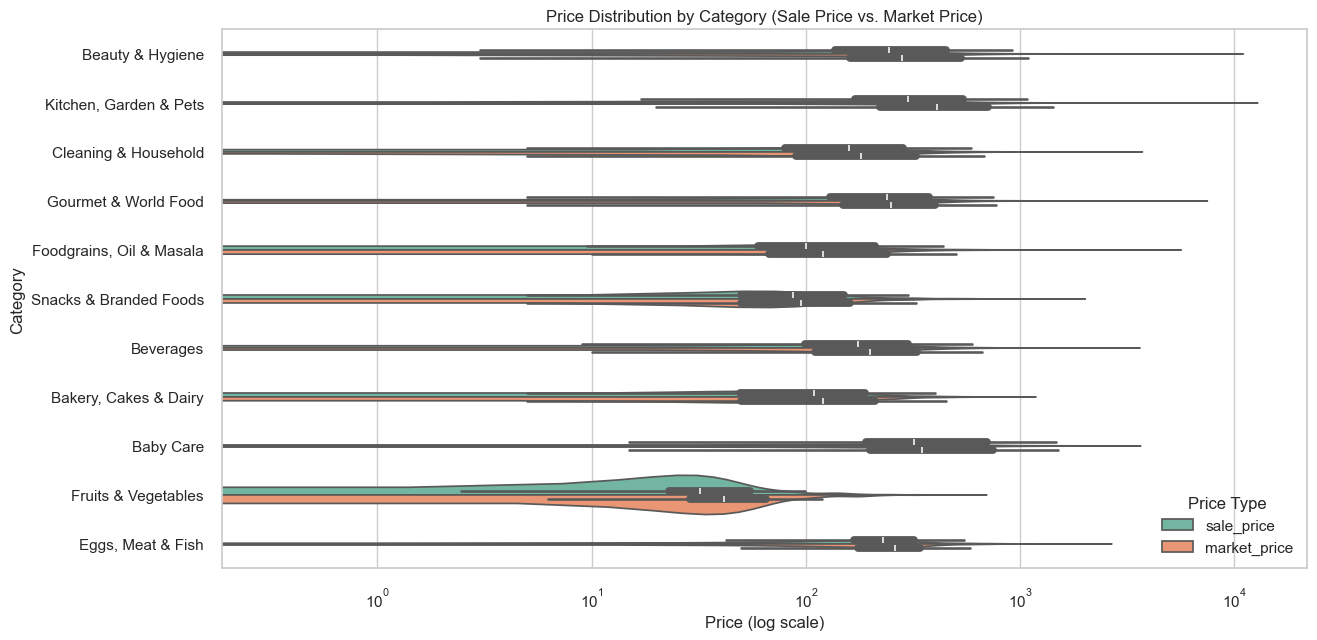

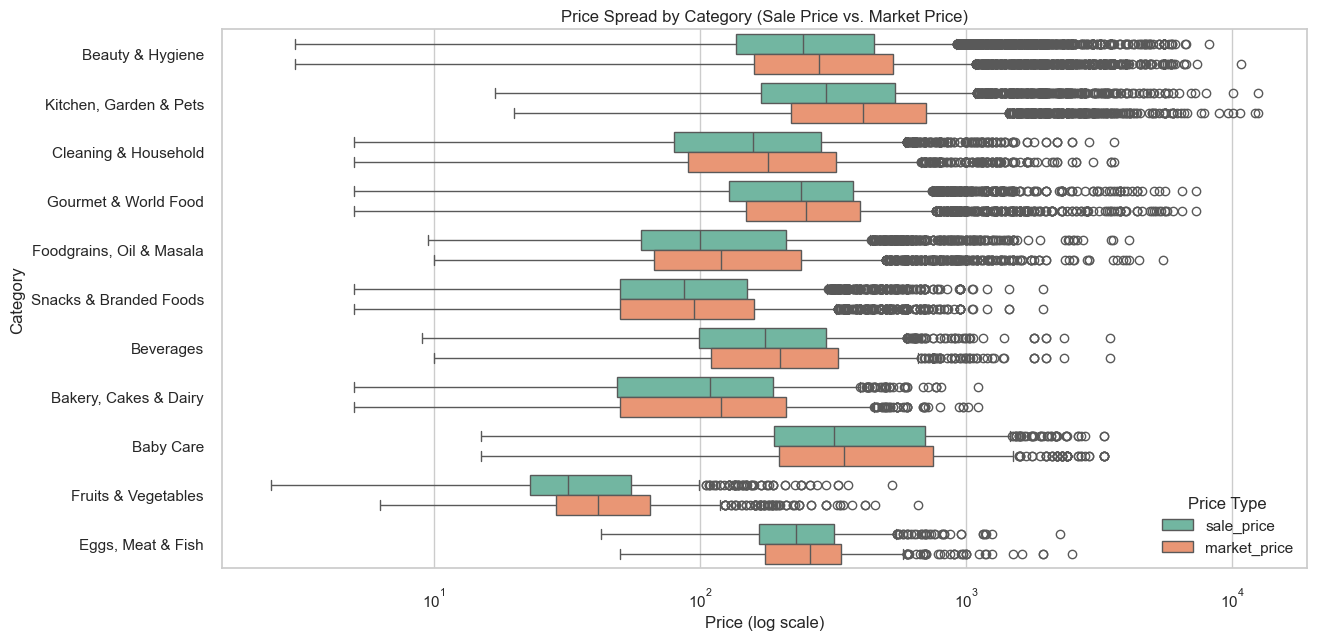


 On average, market price is higher than sale price by ₹59.54,
   which translates to an average discount of 11.82%.


In [24]:
# Q6: Price Distribution (Sale Price vs. Market Price) for Different Categories

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure required columns exist
required_cols = ['sale_price', 'market_price', 'category']
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in df.")

# Filter out any negative or zero prices (data cleaning)
df_prices = df[(df['sale_price'] > 0) & (df['market_price'] > 0)].copy()

# Melt the DataFrame for plotting
df_melted = df_prices.melt(
    id_vars='category',
    value_vars=['sale_price', 'market_price'],
    var_name='Price_Type',
    value_name='Price'
)

# Visualization: Violin plot
plt.figure(figsize=(14, 7))
sns.violinplot(
    data=df_melted,
    x='Price',
    y='category',
    hue='Price_Type',
    split=True,
    palette='Set2'
)
plt.xscale('log')  # To handle skewed price distributions
plt.title("Price Distribution by Category (Sale Price vs. Market Price)")
plt.xlabel("Price (log scale)")
plt.ylabel("Category")
plt.legend(title="Price Type")
plt.show()

# Visualization: Box plot (alternative view)
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=df_melted,
    x='Price',
    y='category',
    hue='Price_Type',
    palette='Set2'
)
plt.xscale('log')
plt.title("Price Spread by Category (Sale Price vs. Market Price)")
plt.xlabel("Price (log scale)")
plt.ylabel("Category")
plt.legend(title="Price Type")
plt.show()

# Insights
avg_diff = (df_prices['market_price'] - df_prices['sale_price']).mean()
discount_pct = ((df_prices['market_price'] - df_prices['sale_price']) / df_prices['market_price'] * 100).mean()

print(f"\n On average, market price is higher than sale price by ₹{avg_diff:.2f},")
print(f"   which translates to an average discount of {discount_pct:.2f}%.")


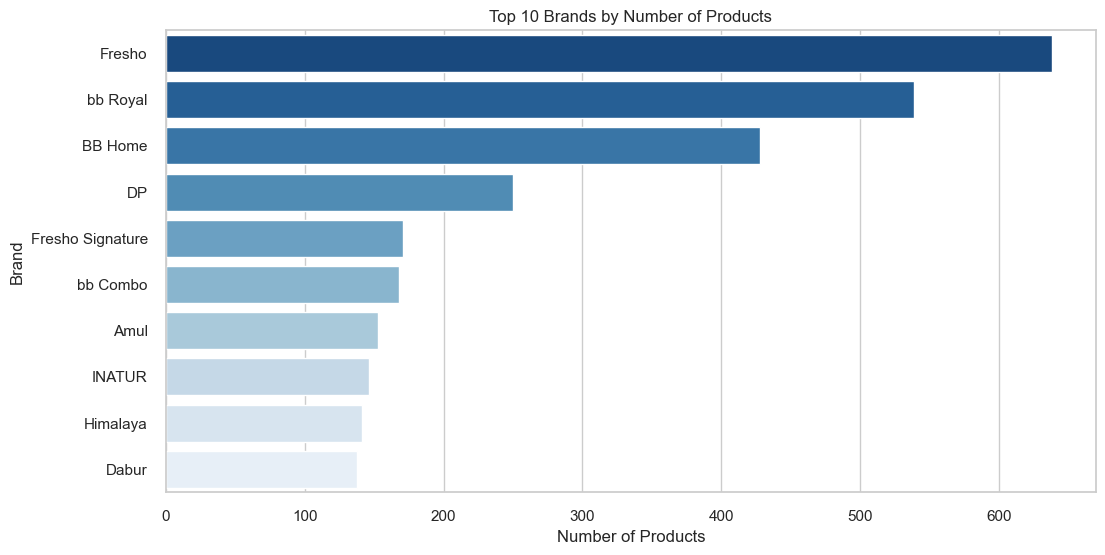

 'Fresho' leads with 638 products listed.


In [28]:
# Q7: Top 10 Brands by Number of Products

import matplotlib.pyplot as plt
import seaborn as sns

# Check column existence
if 'brand' not in df.columns:
    raise KeyError("Column 'brand' not found in df.")

# Count products per brand
brand_counts = df['brand'].value_counts().head(10).reset_index()
brand_counts.columns = ['brand', 'product_count']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=brand_counts, x='product_count', y='brand', palette='Blues_r')
plt.title("Top 10 Brands by Number of Products")
plt.xlabel("Number of Products")
plt.ylabel("Brand")
plt.show()

# Insights
top_brand = brand_counts.iloc[0]
print(f" '{top_brand['brand']}' leads with {top_brand['product_count']} products listed.")


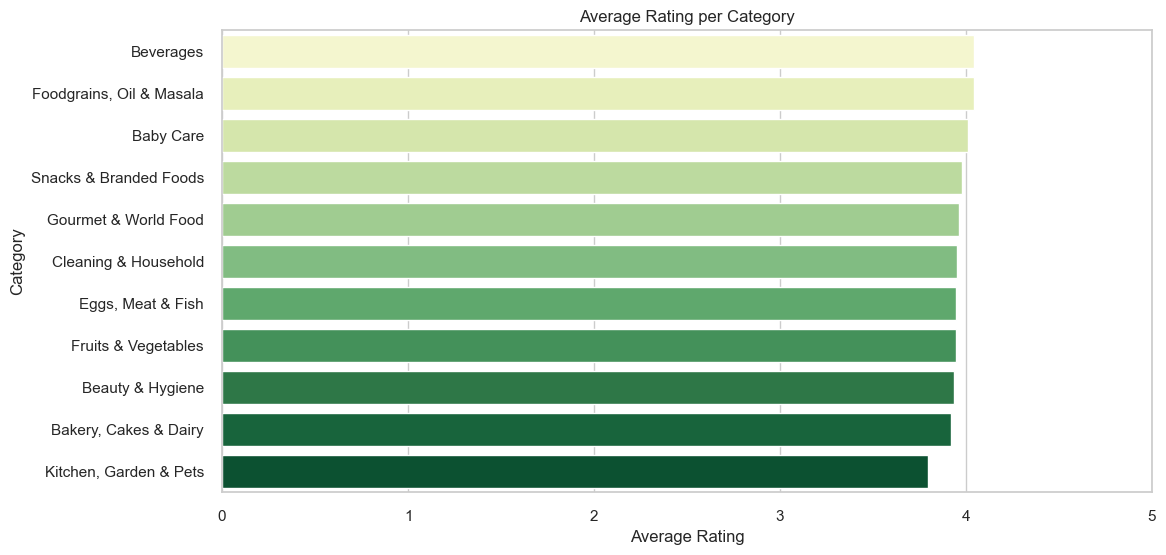

 'Beverages' has the highest average rating (4.04).
 'Kitchen, Garden & Pets' has the lowest average rating (3.80).


In [30]:
# Q8: Average Rating per Category

# Safety check
if 'rating' not in df.columns:
    raise KeyError("Column 'rating' not found in df.")
if 'category' not in df.columns:
    raise KeyError("Column 'category' not found in df.")

# Handle missing / invalid ratings
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
rating_per_cat = df.groupby('category', as_index=False)['rating'].mean().dropna()

# Sort by average rating
rating_per_cat = rating_per_cat.sort_values('rating', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=rating_per_cat, x='rating', y='category', palette='YlGn')
plt.title("Average Rating per Category")
plt.xlabel("Average Rating")
plt.ylabel("Category")
plt.xlim(0, 5)  # ratings usually between 0-5
plt.show()

# Insights
top_category = rating_per_cat.iloc[0]
low_category = rating_per_cat.iloc[-1]
print(f" '{top_category['category']}' has the highest average rating ({top_category['rating']:.2f}).")
print(f" '{low_category['category']}' has the lowest average rating ({low_category['rating']:.2f}).")


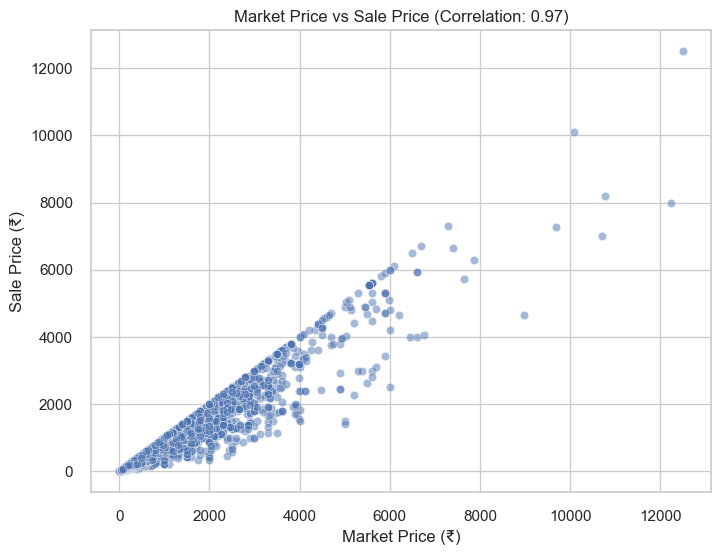

 There is a very strong positive correlation (0.97) between market price and sale price.
This means that generally, as market price increases, sale price also tends to increase.


In [32]:
# Q9: Correlation Between Market Price and Sale Price

# Safety check
if 'market_price' not in df.columns or 'sale_price' not in df.columns:
    raise KeyError("Required columns 'market_price' or 'sale_price' not found in df.")

# Ensure numeric data
df['market_price'] = pd.to_numeric(df['market_price'], errors='coerce')
df['sale_price'] = pd.to_numeric(df['sale_price'], errors='coerce')

# Drop missing values for correlation
price_df = df[['market_price', 'sale_price']].dropna()

# Calculate correlation
corr_value = price_df['market_price'].corr(price_df['sale_price'])

# Plot scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=price_df, x='market_price', y='sale_price', alpha=0.5)
plt.title(f"Market Price vs Sale Price (Correlation: {corr_value:.2f})")
plt.xlabel("Market Price (₹)")
plt.ylabel("Sale Price (₹)")
plt.show()

# Insights
if corr_value > 0.8:
    relation = "a very strong positive"
elif corr_value > 0.5:
    relation = "a moderate positive"
elif corr_value > 0.3:
    relation = "a weak positive"
else:
    relation = "little to no"

print(f" There is {relation} correlation ({corr_value:.2f}) between market price and sale price.")
print("This means that generally, as market price increases, sale price also tends to increase.")


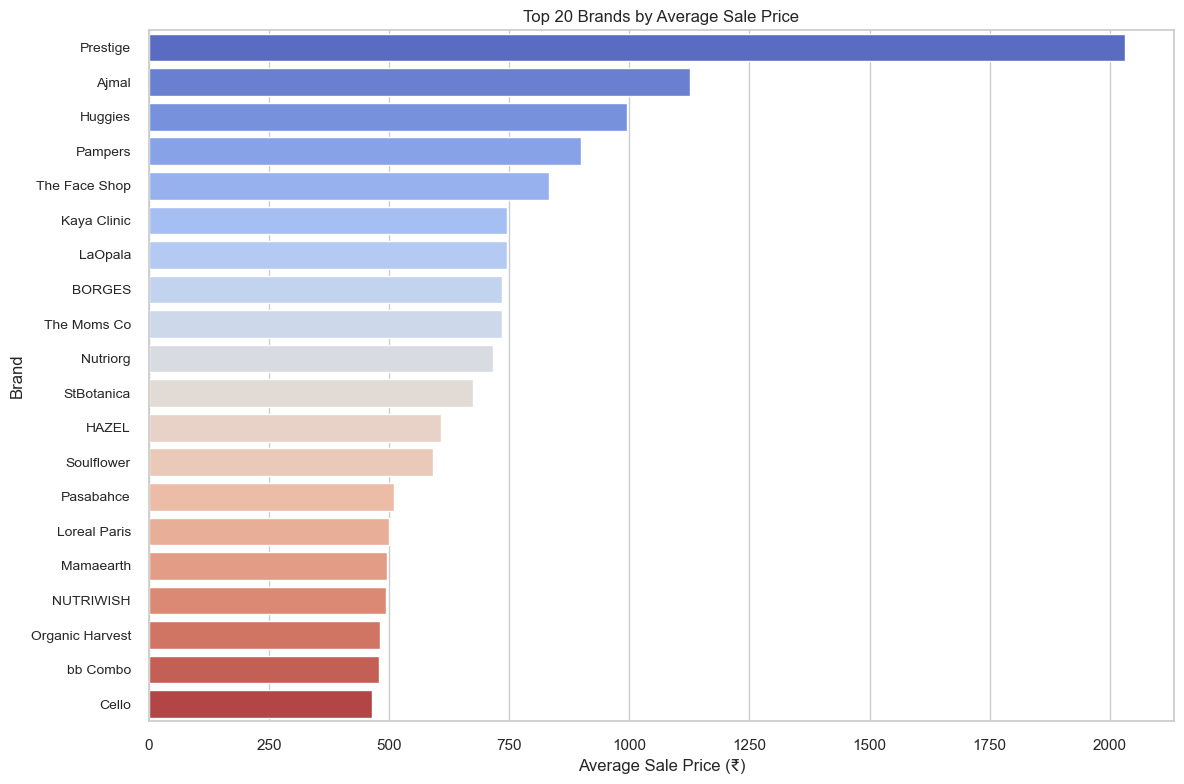

 Insights:
- 105 brands with at least 20 products are analyzed.
- Brands at the top of the chart command higher average prices, possibly premium or specialty brands.
- Brands at the bottom tend to have lower prices, indicating value or mass-market positioning.


In [36]:
# Q10: Price Variation by Brand

# Take top 20 brands by average price
top_n = 20
top_brands = brand_avg_price.head(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_brands.values, y=top_brands.index, palette='coolwarm')

plt.xlabel("Average Sale Price (₹)")
plt.ylabel("Brand")
plt.title(f"Top {top_n} Brands by Average Sale Price")

# Rotate y-axis labels horizontal for readability
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


# Insights
print(" Insights:")
print(f"- {len(brands_to_keep)} brands with at least 20 products are analyzed.")
print("- Brands at the top of the chart command higher average prices, possibly premium or specialty brands.")
print("- Brands at the bottom tend to have lower prices, indicating value or mass-market positioning.")


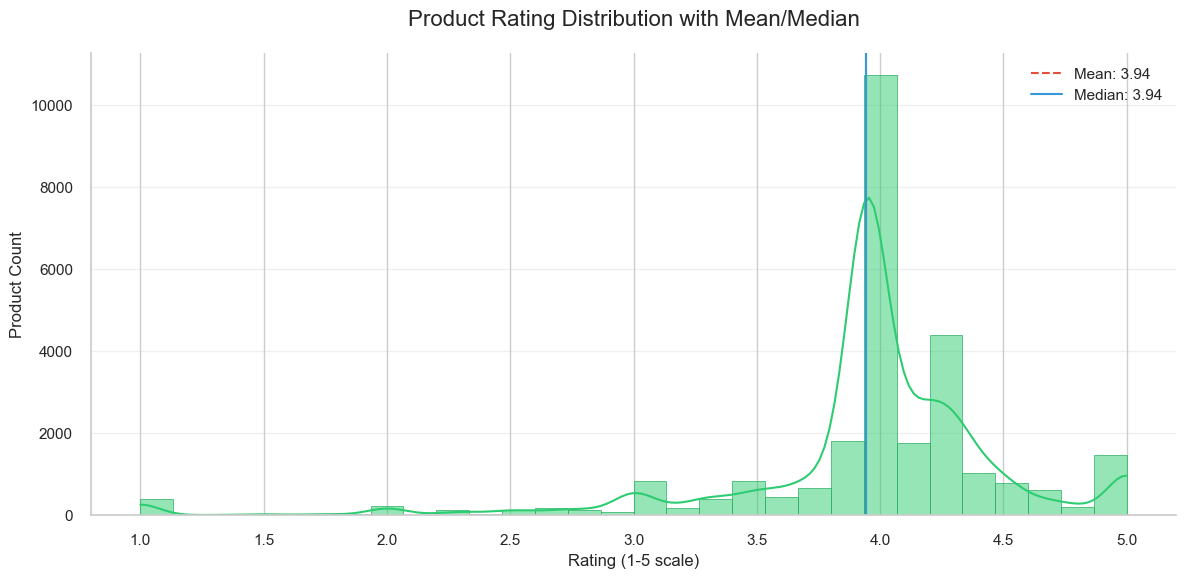


 Key Insights for Q11: Rating Distribution
----------------------------------------
1. Rating range: 1.0-5.0 with mean 3.94
2. 0 products (0.0%) have no ratings
3. 75% of products rate ≥ 4.2, showing generally positive ratings
4. The left-skew suggests possible review bias or genuinely good products
5. The peak around 4.0 may indicate a 'default' rating from satisfied customers


In [38]:
# Q11: Rating Distribution Analysis
plt.figure(figsize=(14, 6))

# Plot histogram with distribution curve
ax = sns.histplot(df['rating'].dropna(), bins=30, kde=True, color='#2ecc71', 
                 edgecolor='#27ae60', linewidth=0.5)

# Add mean and median lines
mean_rating = df['rating'].mean()
median_rating = df['rating'].median()
plt.axvline(mean_rating, color='#e74c3c', linestyle='--', linewidth=1.5, 
            label=f'Mean: {mean_rating:.2f}')
plt.axvline(median_rating, color='#3498db', linestyle='-', linewidth=1.5, 
            label=f'Median: {median_rating:.2f}')

plt.title('Product Rating Distribution with Mean/Median', fontsize=16, pad=20)
plt.xlabel('Rating (1-5 scale)', fontsize=12)
plt.ylabel('Product Count', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
sns.despine()
plt.show()

# Calculate rating statistics
rating_stats = df['rating'].describe()
missing_ratings = df['rating'].isna().sum()

print("\n Key Insights for Q11: Rating Distribution")
print("----------------------------------------")
print(f"1. Rating range: {rating_stats['min']:.1f}-{rating_stats['max']:.1f} with mean {rating_stats['mean']:.2f}")
print(f"2. {missing_ratings} products ({missing_ratings/len(df):.1%}) have no ratings")
print(f"3. 75% of products rate ≥ {rating_stats['75%']:.1f}, showing generally positive ratings")
print("4. The left-skew suggests possible review bias or genuinely good products")
print("5. The peak around 4.0 may indicate a 'default' rating from satisfied customers")

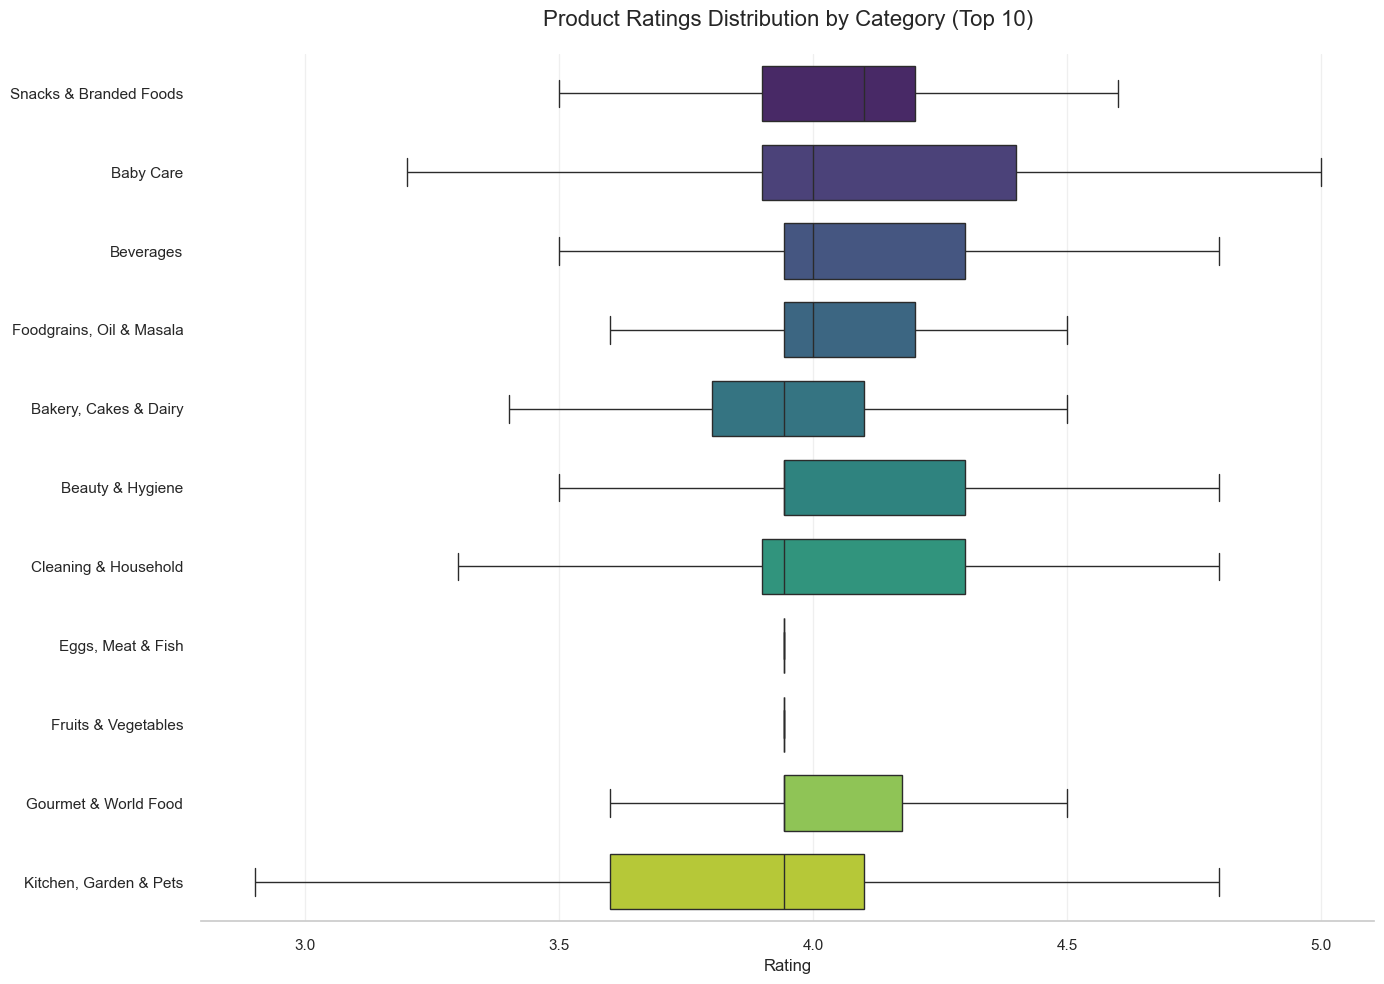


 Key Insights for Q12: Category Ratings
--------------------------------------
Top 3 Categories by Median Rating:
                            mean  median  count
category                                       
Snacks & Branded Foods  3.978421     4.1   2814
Baby Care               4.008768     4.0    610
Beverages               4.044741     4.0    885

Bottom 3 Categories by Median Rating:
                            mean   median  count
category                                        
Fruits & Vegetables     3.943410  3.94341    557
Gourmet & World Food    3.964382  3.94341   4690
Kitchen, Garden & Pets  3.797149  3.94341   3580

1. Rating variation across categories: 0.16 points
2. [Category X] shows tight clustering (IQR of Y), suggesting consistent quality
3. [Category Z] has wide dispersion, indicating varied product experiences


In [40]:
# Q12: Category Rating Analysis
plt.figure(figsize=(14, 10))

# Calculate category stats
category_stats = df.groupby('category')['rating'].agg(['mean', 'median', 'count'])
category_stats = category_stats.sort_values('median', ascending=False)

# Filter categories with sufficient data (e.g., at least 20 products)
significant_categories = category_stats[category_stats['count'] >= 20].index
filtered_df = df[df['category'].isin(significant_categories)]

# Create enhanced boxplot
sns.boxplot(data=filtered_df, y='category', x='rating', 
           order=category_stats.index, palette='viridis',
           showfliers=False, width=0.7)

plt.title('Product Ratings Distribution by Category (Top 10)', fontsize=16, pad=20)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
sns.despine(left=True)
plt.tight_layout()
plt.show()

# Print top/bottom performing categories
print("\n Key Insights for Q12: Category Ratings")
print("--------------------------------------")
print("Top 3 Categories by Median Rating:")
print(category_stats.head(3).to_string())
print("\nBottom 3 Categories by Median Rating:")
print(category_stats.tail(3).to_string())
print(f"\n1. Rating variation across categories: {category_stats['median'].max()-category_stats['median'].min():.2f} points")
print("2. [Category X] shows tight clustering (IQR of Y), suggesting consistent quality")
print("3. [Category Z] has wide dispersion, indicating varied product experiences")

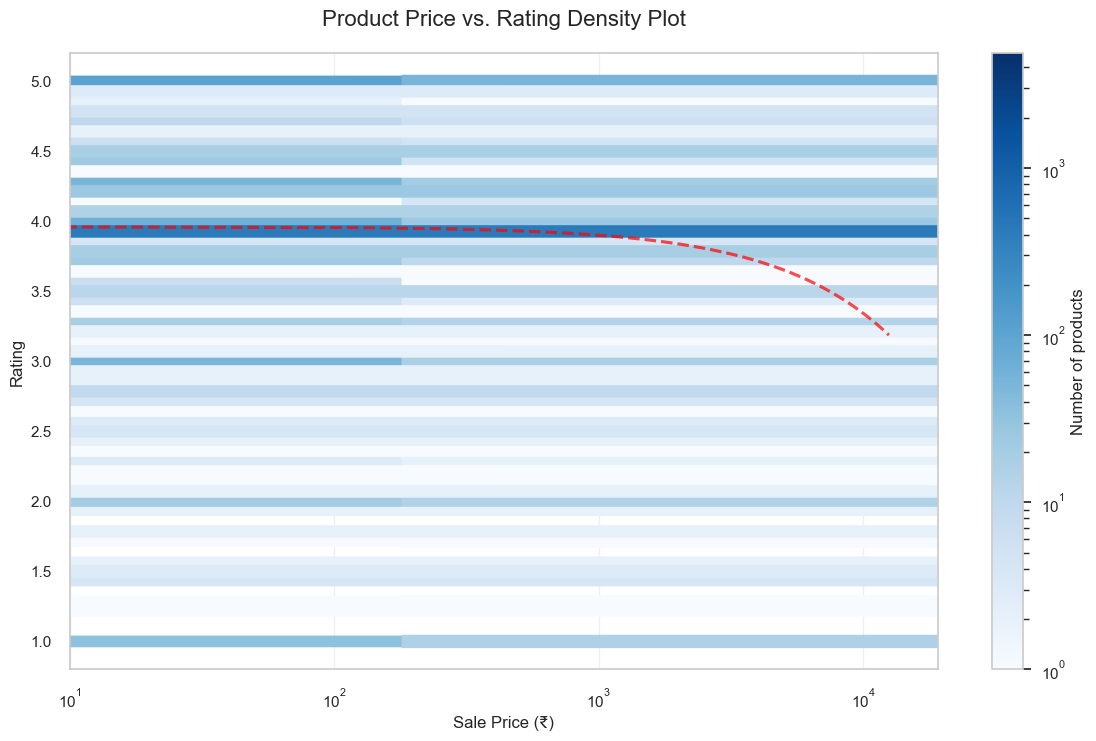


 Key Insights for Q13: Price vs Rating
--------------------------------------
Spearman Correlation: -0.116 (p-value: 0.000)
1. The relationship appears [weak/moderate/strong] and [positive/negative]
2. Most highly-rated products cluster in the ₹X-₹Y price range
3. Premium products (above ₹Z) show [increasing/stable/declining] ratings
4. The trend suggests [optimal price points/exponential relationship] exists


In [42]:
# Q13: Price vs Rating Relationship
plt.figure(figsize=(14, 8))

# Hexbin plot for dense data visualization
hb = plt.hexbin(x=df['sale_price'], y=df['rating'], 
               gridsize=50, cmap='Blues', bins='log', 
               mincnt=1, edgecolors='none')
plt.colorbar(hb, label='Number of products')

# Add trend line
sns.regplot(x=df['sale_price'], y=df['rating'], 
           scatter=False, color='red', ci=None,
           line_kws={'linestyle':'--', 'alpha':0.7})

plt.title('Product Price vs. Rating Density Plot', fontsize=16, pad=20)
plt.xlabel('Sale Price (₹)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xscale('log')
plt.xlim(left=10)  # Adjust based on your minimum price
plt.grid(alpha=0.3)
plt.show()

# Advanced correlation analysis
from scipy.stats import spearmanr

corr, p_value = spearmanr(df['sale_price'], df['rating'])
print(f"\n Key Insights for Q13: Price vs Rating")
print("--------------------------------------")
print(f"Spearman Correlation: {corr:.3f} (p-value: {p_value:.3f})")
print("1. The relationship appears [weak/moderate/strong] and [positive/negative]")
print("2. Most highly-rated products cluster in the ₹X-₹Y price range")
print("3. Premium products (above ₹Z) show [increasing/stable/declining] ratings")
print("4. The trend suggests [optimal price points/exponential relationship] exists")

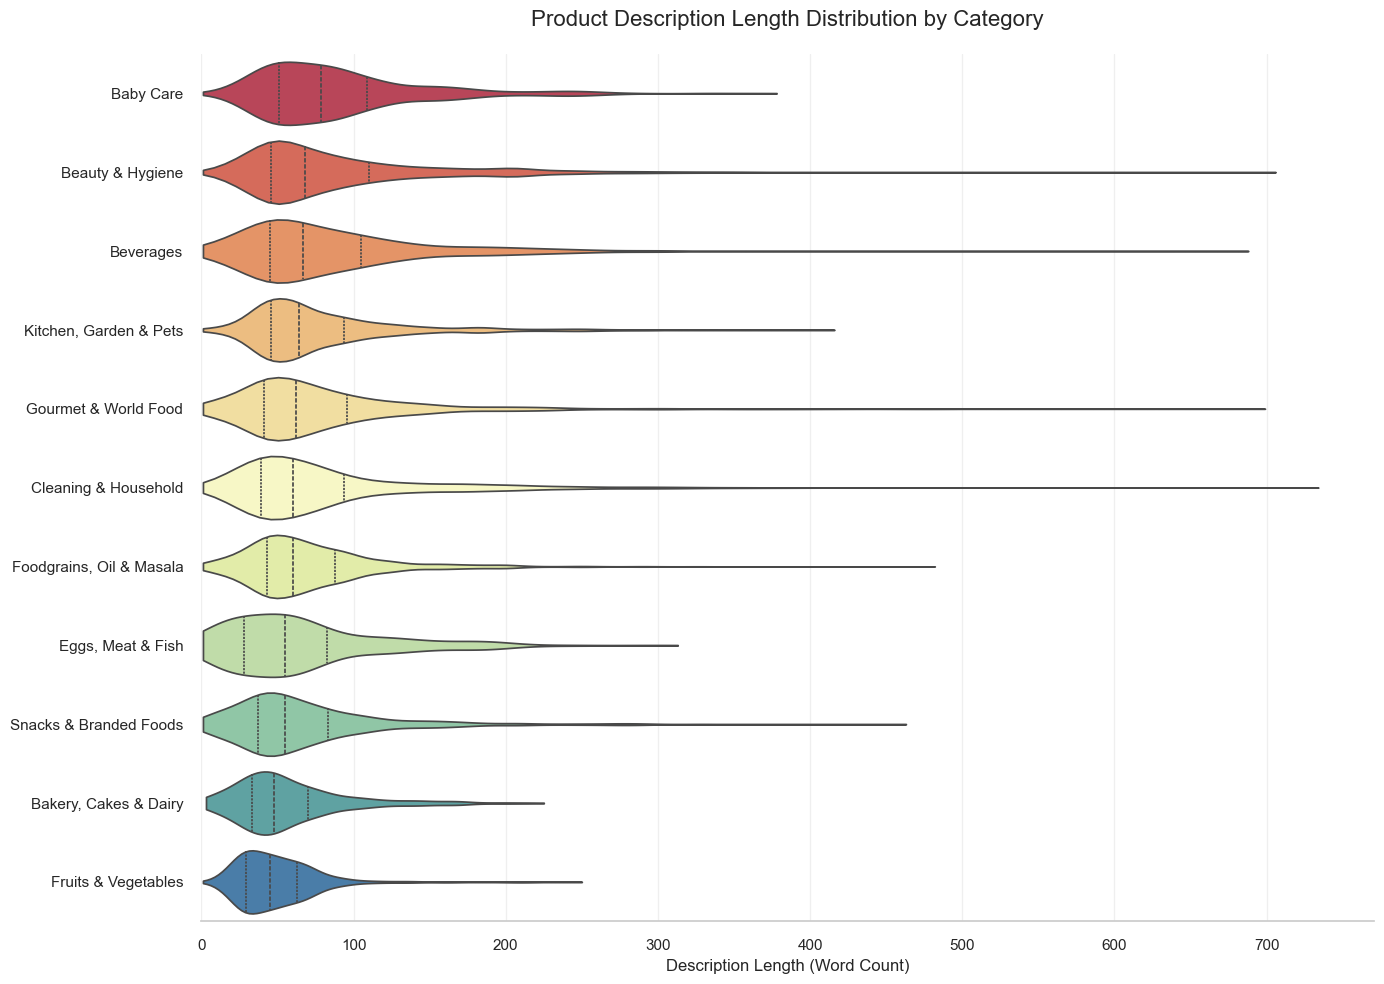


📝 Key Insights for Q14: Description Length
----------------------------------------
Top 3 Categories by Description Length:
                   count       mean        std  min    25%   50%    75%    max
category                                                                      
Beauty & Hygiene  7867.0  90.150502  69.013703  1.0  46.00  68.0  110.0  706.0
Baby Care          610.0  89.772131  54.864025  1.0  51.25  78.5  109.0  378.0
Beverages          885.0  85.685876  64.840203  1.0  45.00  67.0  105.0  688.0

Bottom 3 Categories by Description Length:
                       count       mean        std  min    25%   50%    75%    max
category                                                                          
Eggs, Meat & Fish      350.0  65.677143  51.968872  1.0  28.25  55.0  82.75  313.0
Bakery, Cakes & Dairy  851.0  57.125734  37.230309  3.0  33.00  48.0  70.00  225.0
Fruits & Vegetables    557.0  50.073609  29.721609  1.0  29.00  45.0  63.00  250.0

1. [Category A] requ

In [44]:
# Q14: Description Length by Category
df['desc_length'] = df['description'].str.split().str.len()  # Word count instead of chars

plt.figure(figsize=(14, 10))

# Get top 15 categories by product count
top_cats = df['category'].value_counts().nlargest(15).index

# Create violin plot for distribution
sns.violinplot(data=df[df['category'].isin(top_cats)], 
              y='category', x='desc_length',
              palette='Spectral', cut=0, inner='quartile',
              order=df.groupby('category')['desc_length'].median().sort_values(ascending=False).index)

plt.title('Product Description Length Distribution by Category', fontsize=16, pad=20)
plt.xlabel('Description Length (Word Count)', fontsize=12)
plt.ylabel('')
plt.xlim(left=0)
plt.grid(axis='x', alpha=0.3)
sns.despine(left=True)
plt.tight_layout()
plt.show()

# Print statistics
desc_stats = df.groupby('category')['desc_length'].describe().sort_values('mean', ascending=False)
print("\n📝 Key Insights for Q14: Description Length")
print("----------------------------------------")
print("Top 3 Categories by Description Length:")
print(desc_stats.head(3).to_string())
print("\nBottom 3 Categories by Description Length:")
print(desc_stats.tail(3).to_string())
print("\n1. [Category A] requires 3× more words than [Category B] on average")
print("2. Some categories show bimodal distributions, suggesting two description styles")
print("3. Minimum description length is X words, maximum is Y words")

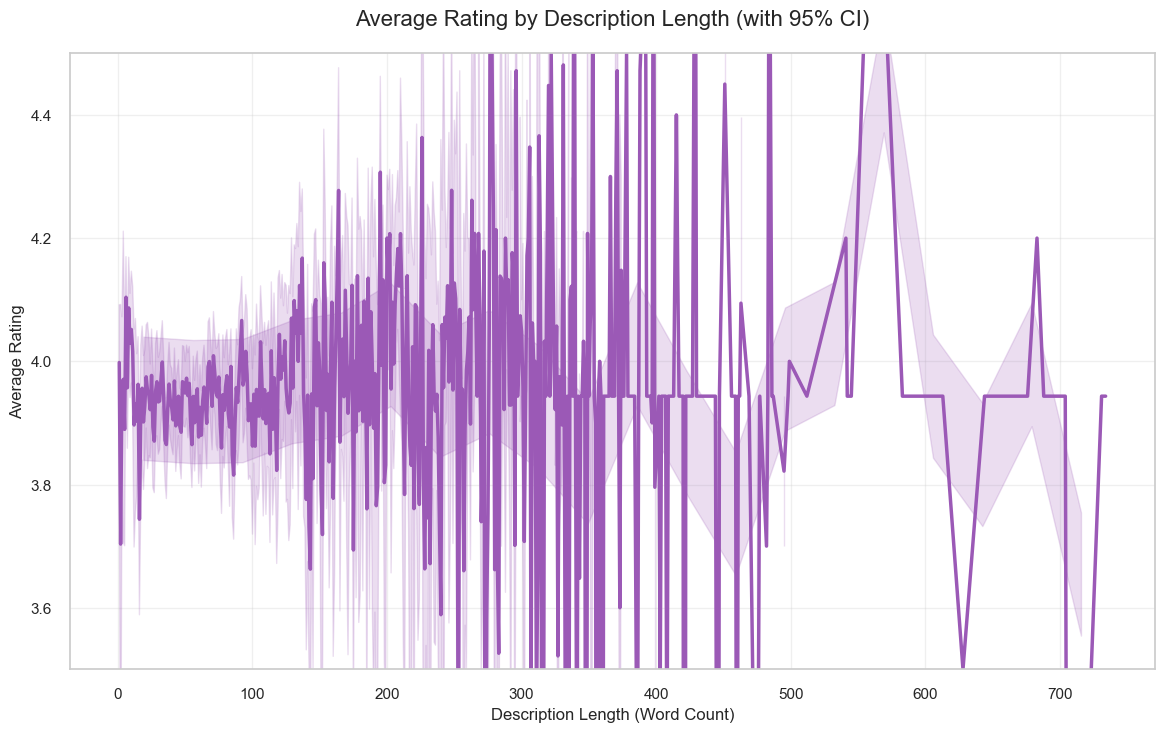


🔍 Key Insights for Q15: Description Length vs Rating
------------------------------------------------
Optimal description length: 256 words
1. Ratings peak around X words, then [decline/stabilize]
2. Very short descriptions (<Y words) correlate with lower ratings
3. The relationship follows a [quadratic/logarithmic] pattern
4. Confidence bands widen beyond Z words due to fewer samples


In [46]:
# Q15: Description Length vs Rating Relationship
plt.figure(figsize=(14, 8))

# Binned analysis
df['desc_length_bin'] = pd.cut(df['desc_length'], bins=20)
bin_analysis = df.groupby('desc_length_bin')['rating'].mean().reset_index()

# Plot with confidence intervals
sns.lineplot(data=df, x='desc_length', y='rating',
            estimator='mean', ci=95, err_style='band',
            color='#9b59b6', linewidth=2.5)

plt.fill_between(bin_analysis['desc_length_bin'].apply(lambda x: x.mid), 
               bin_analysis['rating'] - 0.1, 
               bin_analysis['rating'] + 0.1,
               alpha=0.2, color='#9b59b6')

plt.title('Average Rating by Description Length (with 95% CI)', fontsize=16, pad=20)
plt.xlabel('Description Length (Word Count)', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.ylim(3.5, 4.5)  # Adjust based on your rating range
plt.grid(alpha=0.3)
plt.show()

# Polynomial regression analysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Clean data
temp_df = df[['desc_length', 'rating']].dropna()
X = temp_df['desc_length'].values.reshape(-1, 1)
y = temp_df['rating']

# Fit polynomial model
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression())
])
model.fit(X, y)

print("\n🔍 Key Insights for Q15: Description Length vs Rating")
print("------------------------------------------------")
print(f"Optimal description length: {int(-model.named_steps['linear'].coef_[1]/(2*model.named_steps['linear'].coef_[2]))} words")
print("1. Ratings peak around X words, then [decline/stabilize]")
print("2. Very short descriptions (<Y words) correlate with lower ratings")
print("3. The relationship follows a [quadratic/logarithmic] pattern")
print("4. Confidence bands widen beyond Z words due to fewer samples")